## Libraries and setup

In [2]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown, Latex

In [3]:
from utils import wandb_utils

In [5]:
experiment_tags = ['e16_finaljan_allerm_replicated',
'e17_finaljan_constant_constrained_replicated',
'e18_icml_constant_constrained_loose',
'e19_icml_resilience_val',
'e19_icml_resilience_train',
'e20_icml_monotonic',
'e20_icml_monotonic_no_resilience',
'e21_icml_static_linear_no_resilience',
'e21_icml_static_linear_resilience',]

backup_data=wandb_utils.get_experiment_data("Autoformer","alelab",experiment_tags=experiment_tags,query_dict={"$and": [
                        {"tags": {"$in": experiment_tags}},
                        {"state": "finished"},
                        {"config.seed": 2021}
        ]})

 60%|█████▉    | 484/809 [38:05<24:58,  4.61s/it]  

In [8]:
backup_data.to_pickle("icml_backup_data.pkl")
backup_data.to_csv("icml_backup_data.csv",index=False)

In [9]:
#df = raw_df.copy()
raw_df = df.copy()

In [16]:
# df = wandb_utils.get_experiment_data("Autoformer","alelab",experiment_tags=[
#     #"e16_finaljan_allerm_replicated",
#     "e19_icml_resilience_val",
# ])
# raw_df = df.copy() #as backup

In [10]:
#TODO deleteme
df = df[df.seed==2021].copy()
df.run_id.nunique()

96

In [13]:
df.groupby(['data_path','model','pred_len','seed'])['run_id'].nunique().reset_index()

,data_path,model,pred_len,seed,run_id
0,electricity.csv,Autoformer,96,2021,2
1,electricity.csv,Autoformer,192,2021,2
2,electricity.csv,Autoformer,336,2021,2
3,electricity.csv,Autoformer,720,2021,2
4,electricity.csv,Informer,96,2021,2
5,electricity.csv,Informer,192,2021,2
6,electricity.csv,Informer,336,2021,2
7,electricity.csv,Informer,720,2021,2
8,electricity.csv,Reformer,96,2021,2
9,electricity.csv,Reformer,192,2021,2


## Data processing
This section contains processing specific to this experiment set. If you clone this notebook. Remove or refactor this section.

### Label constraint_levels (`constraint_idx` column)
useful for joining when the constraint values are different for each model.

In [17]:
# There are three constraint levels per run, add a rank column, sorted by constraint level.
df=df.copy()

df.loc[df.constraint_type==CONSTRAINT_TYPE,'constraint_idx'] = 1
df.loc[df.constraint_type=='erm','constraint_idx'] = 0
df['constraint_idx'] = df['constraint_idx'].astype(int)
ranked_constraint_levels_summary = df[['run_id','data_path','model','pred_len','constraint_type','constraint_level','constraint_idx']].drop_duplicates('run_id').sort_values(['data_path','model','pred_len','constraint_level'])
print("Sanity checking on the summary")
ranked_constraint_levels_summary

Sanity checking on the summary


,run_id,data_path,model,pred_len,constraint_type,constraint_level,constraint_idx
80352,uglzgsuo,electricity.csv,Autoformer,96,erm,-1.0,0
31968,6j1pxpzj,electricity.csv,Autoformer,96,static_linear,NaN,1
79776,j30xdff9,electricity.csv,Autoformer,192,erm,-1.0,0
31392,zc7saoc3,electricity.csv,Autoformer,192,static_linear,NaN,1
78768,0roswz2a,electricity.csv,Autoformer,336,erm,-1.0,0
...,...,...,...,...,...,...,...
35424,3ddt6h3k,weather.csv,Transformer,192,static_linear,NaN,1
82800,3pkwpeuw,weather.csv,Transformer,336,erm,-1.0,0
34416,ptpvenhb,weather.csv,Transformer,336,static_linear,NaN,1
80640,2ldijjak,weather.csv,Transformer,720,erm,-1.0,0


### Broadcast ERM runs with constraint levels (`df_to_plot`)
to compare ERM with constrained, we need every ERM run repeated to pair it with a constrained run.

In [20]:
df_constrained = df.query('type=="Constrained"').copy()
df_erm = df.query('type=="ERM"').copy()
#(data_path,model,pred_len,constraint_level,constrained_unconstraled)
distinct_constraints = df_constrained[['data_path','model','pred_len','constraint_type']].drop_duplicates()

# crossjoin the ERM mse to all constraint levels
df_erm_w_broadcasted_constraint_levels = df_erm.drop(columns=['constraint_type']).merge(distinct_constraints,on=['data_path','model','pred_len'],how='left')
df_to_plot = pd.concat([df_constrained,df_erm_w_broadcasted_constraint_levels],axis=0)

# sanity check
display(df_erm_w_broadcasted_constraint_levels.shape)
print(f"Three constraints per experiment, broadcasted dataset size be equal to {df_erm.shape[0]*1}")
display(df_to_plot.shape)
print(f"Final dataset size should be equal to {df_constrained.shape[0]+df_erm.shape[0]*1}")

(48384, 86)

Three constraints per experiment, broadcasted dataset size be equal to 48384


(96768, 86)

Final dataset size should be equal to 96768


### Add constraint violation metric

In [21]:
# Adding the constraint violation column
df_to_plot["constraint_violation"] = (df_to_plot.mse-df_to_plot.constraint_level).clip(lower=0)
df_to_plot['is_infeasible'] = (df_to_plot.constraint_violation>0)*1

# sanity check
dd=df_to_plot[['run_id','model','type','step','mse','constraint_level','constraint_violation','is_infeasible']] 
print("For ERM")
display(dd.query('type=="ERM"').query('constraint_violation>0').head())
print("For Constrained")
display(dd.query('type=="Constrained"').query('constraint_violation>0').head())


For ERM


,run_id,model,type,step,mse,constraint_level,constraint_violation,is_infeasible
0,k6rl9exh,Transformer,ERM,0,0.095688,-1.0,1.095688,1
1,k6rl9exh,Transformer,ERM,1,0.060131,-1.0,1.060131,1
2,k6rl9exh,Transformer,ERM,2,0.058476,-1.0,1.058476,1
3,k6rl9exh,Transformer,ERM,3,0.058762,-1.0,1.058762,1
4,k6rl9exh,Transformer,ERM,4,0.058699,-1.0,1.058699,1


For Constrained


,run_id,model,type,step,mse,constraint_level,constraint_violation,is_infeasible


### Summary metrics per run (unused)
Summarize all three runs into metrics per split by averaging mse and constraint levels.

In [22]:
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric

summary_metrics_per_run = df_to_plot.groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"
    ])['mse','constraint_violation','infeasible_rate','run_id'].aggregate(
        mse=('mse','mean'),
        #std_mse=('mse','std'),
        mcv=('constraint_violation','mean'),
        #std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_metrics = summary_metrics_per_run.groupby([
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',"constraint_level","pred_len","data_path",
    "split"]).aggregate(
        mse=('mse','mean'),
        std_mse=('mse','std'),
        mcv=('mcv','mean'),
        std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean')
    ).reset_index()
display(summary_metrics_per_run.shape)
display(summary_metrics.shape)
summary_metrics.head()

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


(144, 12)

(144, 14)

,Algorithm,model,type,constraint_level,pred_len,data_path,split,mse,std_mse,mcv,std_mcv,mean_infeasible_rate,std_infeasible_rate,run_count
0,AllModels_electricity.csv Autoformer,Autoformer,ERM,-1.0,96,electricity.csv,test,0.20399,NaN,1.20399,NaN,1.0,NaN,1.0
1,AllModels_electricity.csv Autoformer,Autoformer,ERM,-1.0,96,electricity.csv,train,0.11989,NaN,1.11989,NaN,1.0,NaN,1.0
2,AllModels_electricity.csv Autoformer,Autoformer,ERM,-1.0,96,electricity.csv,val,0.16142,NaN,1.16142,NaN,1.0,NaN,1.0
3,AllModels_electricity.csv Autoformer,Autoformer,ERM,-1.0,192,electricity.csv,test,0.21535,NaN,1.21535,NaN,1.0,NaN,1.0
4,AllModels_electricity.csv Autoformer,Autoformer,ERM,-1.0,192,electricity.csv,train,0.14774,NaN,1.14774,NaN,1.0,NaN,1.0


**END OF PREPROCESSING**

---
---

## Plots

### ERM vs. Constrained on 50th percentile (one seed)
TO DO: Reproduce the ERM vs constrained per model for each window size. Try to unify into one plot if possible.

#### **ERM Vs Constrained 96 (split=test, constraint_idx=1)**

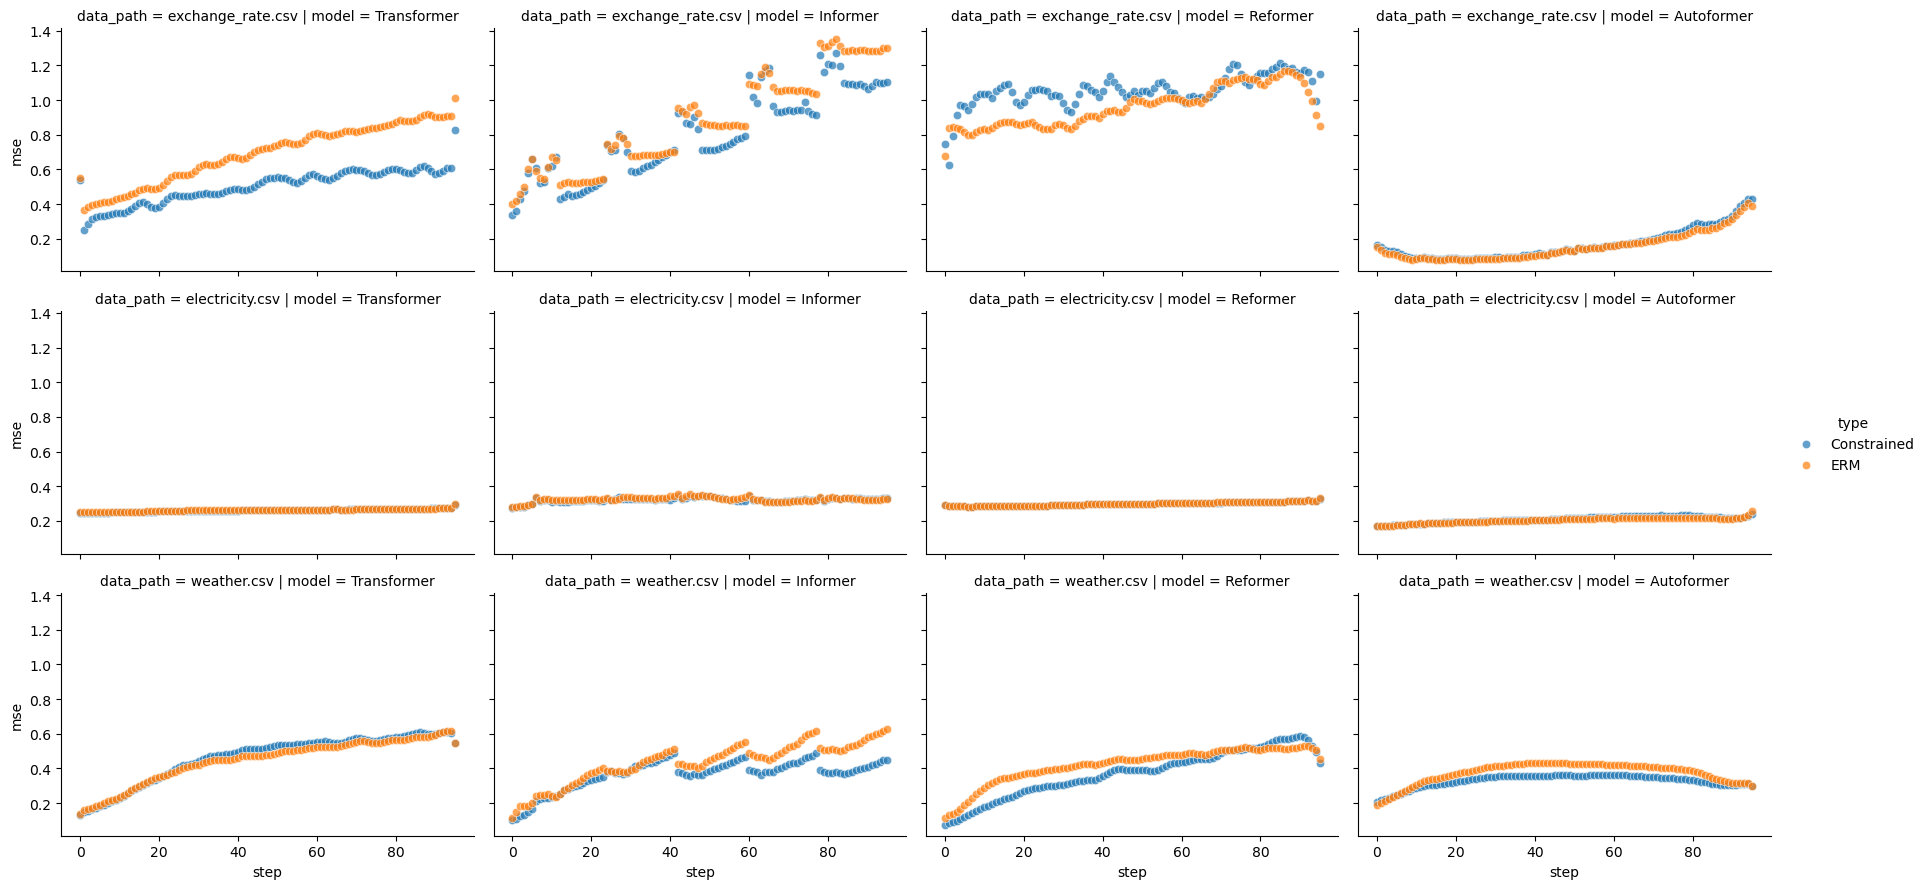

#### **ERM Vs Constrained 192 (split=test, constraint_idx=1)**

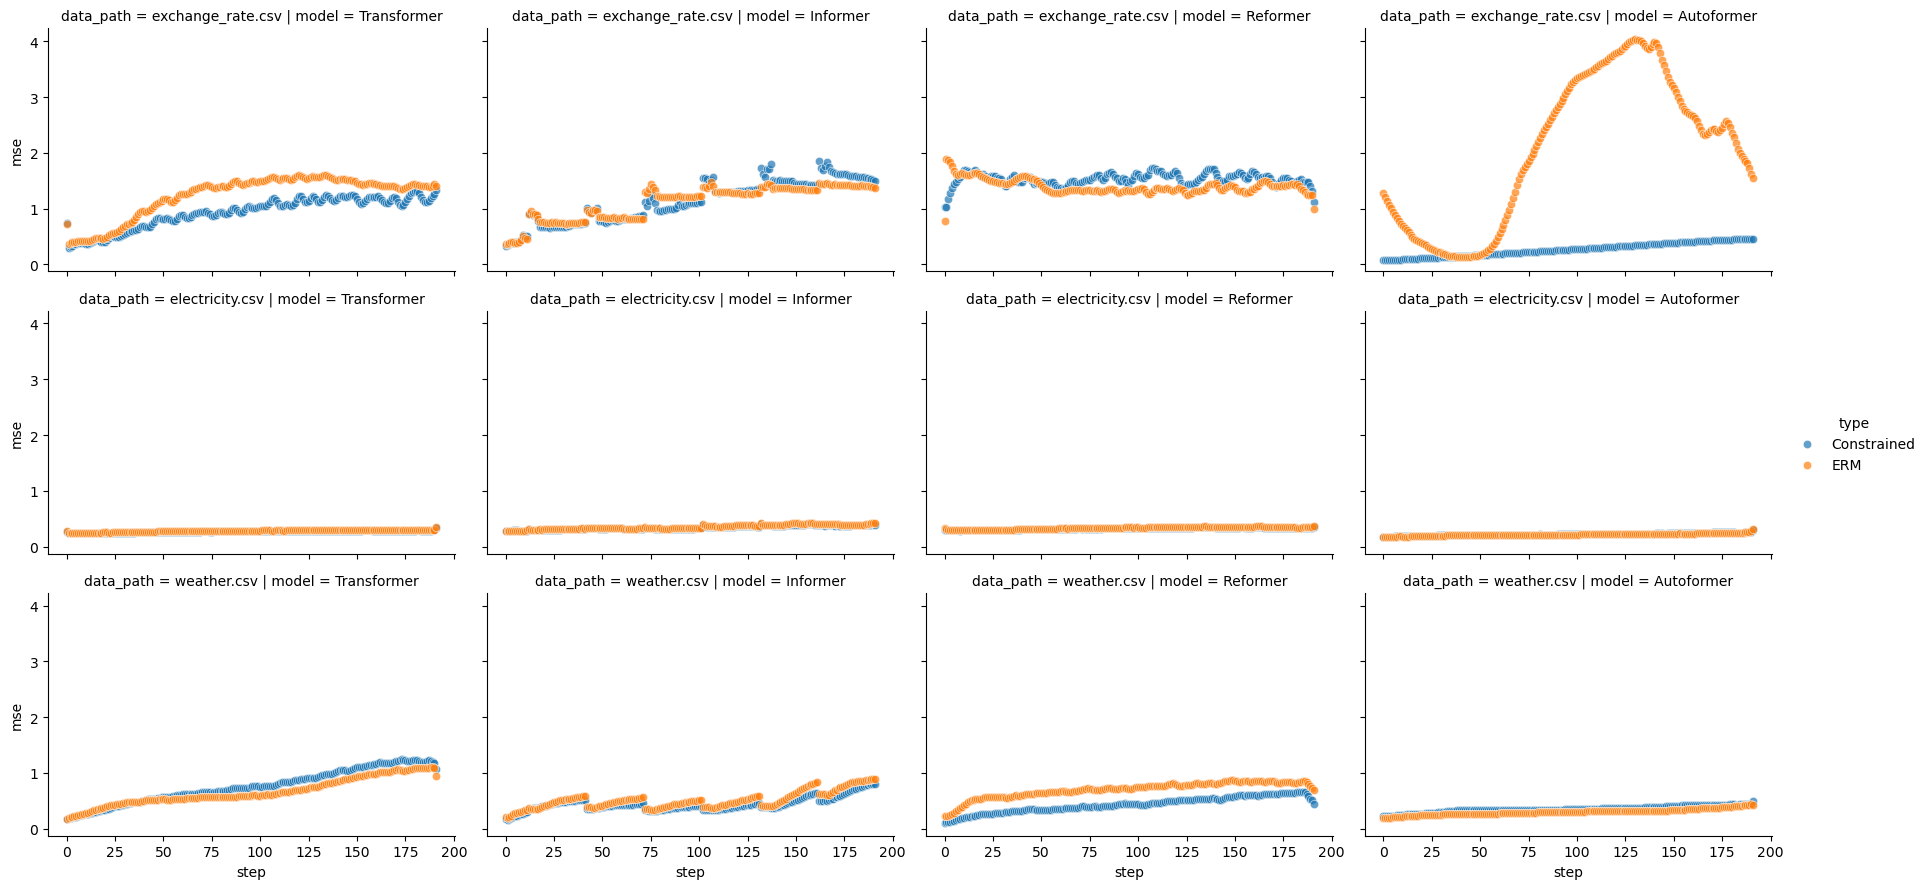

#### **ERM Vs Constrained 336 (split=test, constraint_idx=1)**

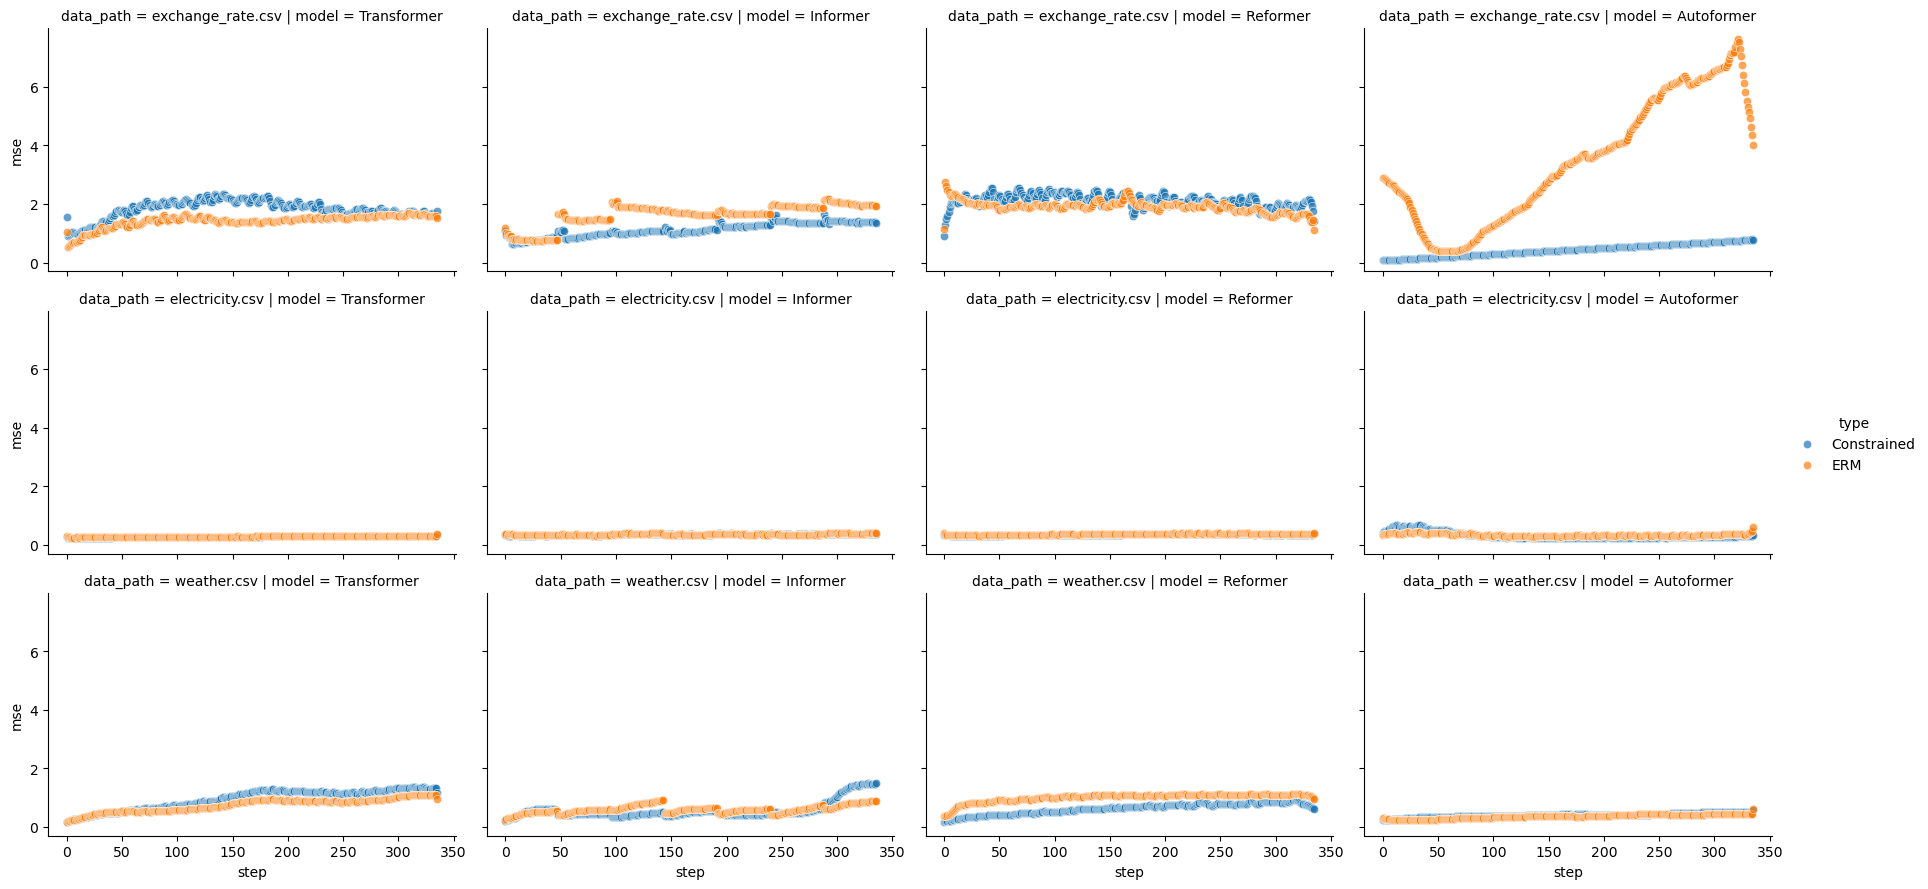

#### **ERM Vs Constrained 720 (split=test, constraint_idx=1)**

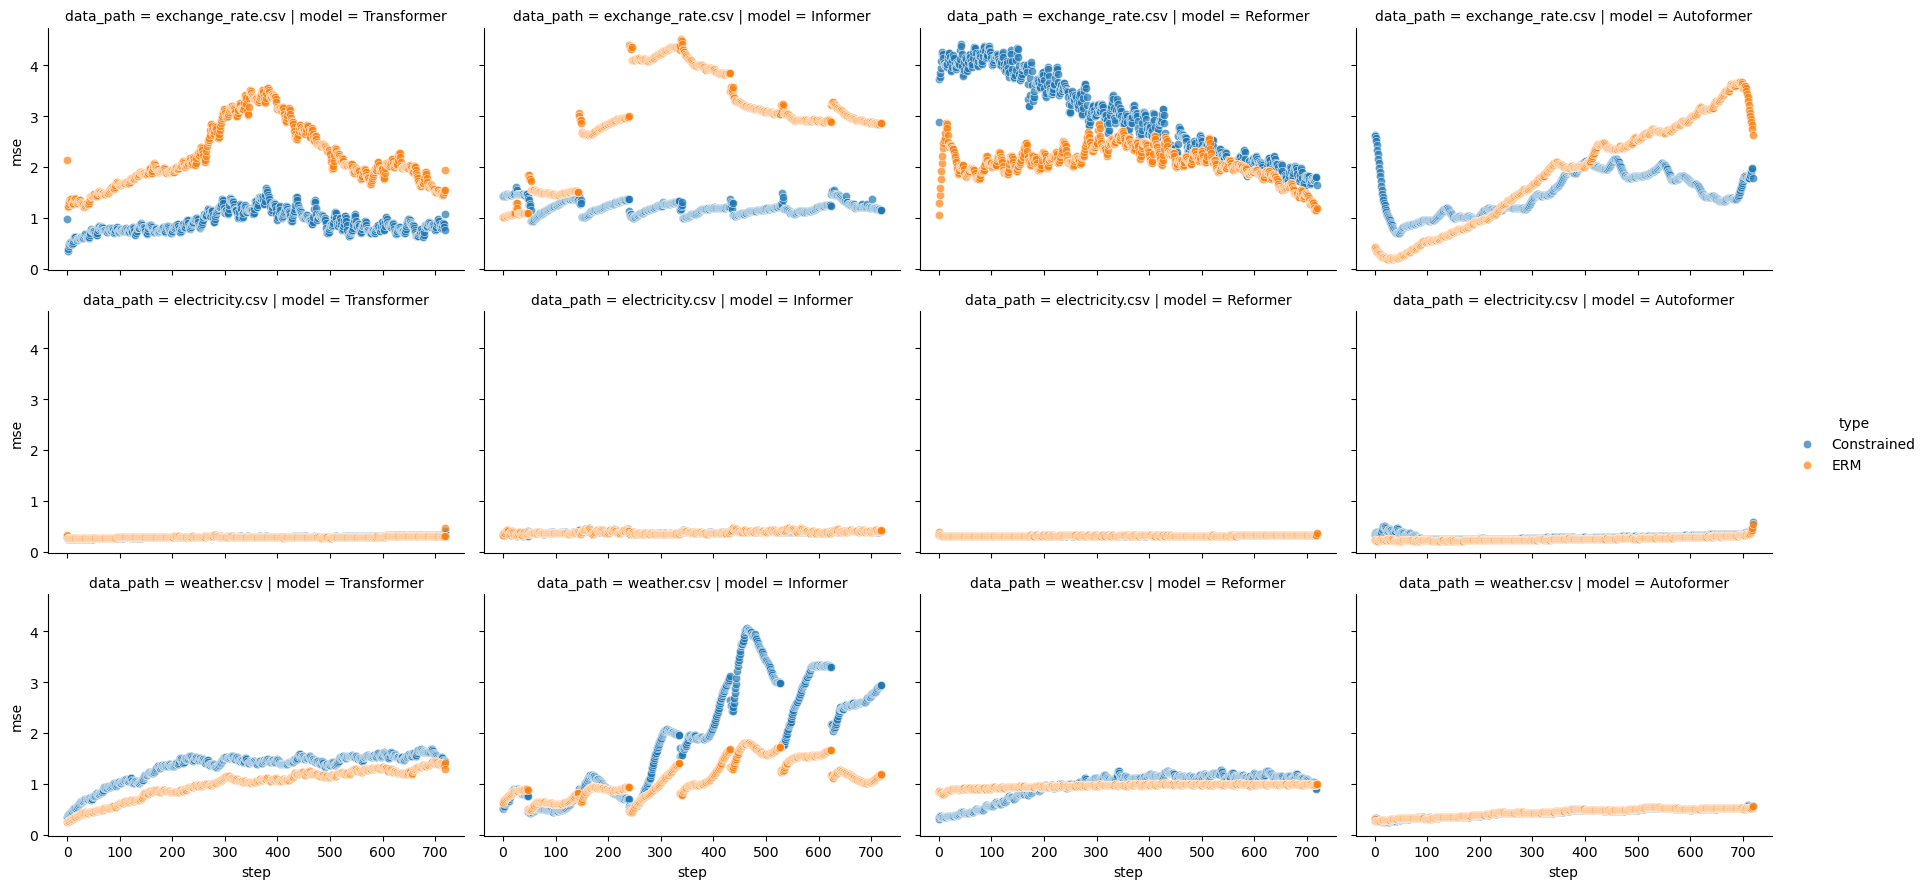

In [23]:
# PARAMS
split="test"
constraint_idx = 1 # use the 50 percentile constraint to plot 1=25,2=50,3=75
seed=2021

# Filter
df_pct50_and_erm = df_to_plot[(df_to_plot.constraint_idx.isin([0,constraint_idx])) & (df_to_plot.seed==seed) & (df_to_plot.split==split)].copy()

PRED_LENS=sorted(df_to_plot.pred_len.unique().tolist())
#PRED_LENS=[96]
for pred_len in PRED_LENS:
    # Add data for constant line
    df_current_plot = df_pct50_and_erm.query('pred_len==@pred_len').copy()
    #constraint_level = df_current_plot.constraint_level.unique()[0]
    #df_current_plot['constraint_level'] = constraint_level
    display(Markdown(f"#### **ERM Vs Constrained {pred_len} (split={split}, constraint_idx={constraint_idx})**"))

    g = sns.FacetGrid(df_current_plot, col='model', row='data_path', hue='type', height=3, aspect=1.5, legend_out=True)
    #g.map(sns.lineplot, "step", "constraint_level", alpha=.7)
    g.map(sns.scatterplot, "step", "mse", alpha=.7)
    g.add_legend()
    #TODO fix and uncomment
    #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{pred_len}_{str(constraint_level).replace('.','')}.png")
    plt.show()

### Multipliers over the window

#### **Multipliers vs loss 96 (split=train, constraint_idx=2)**

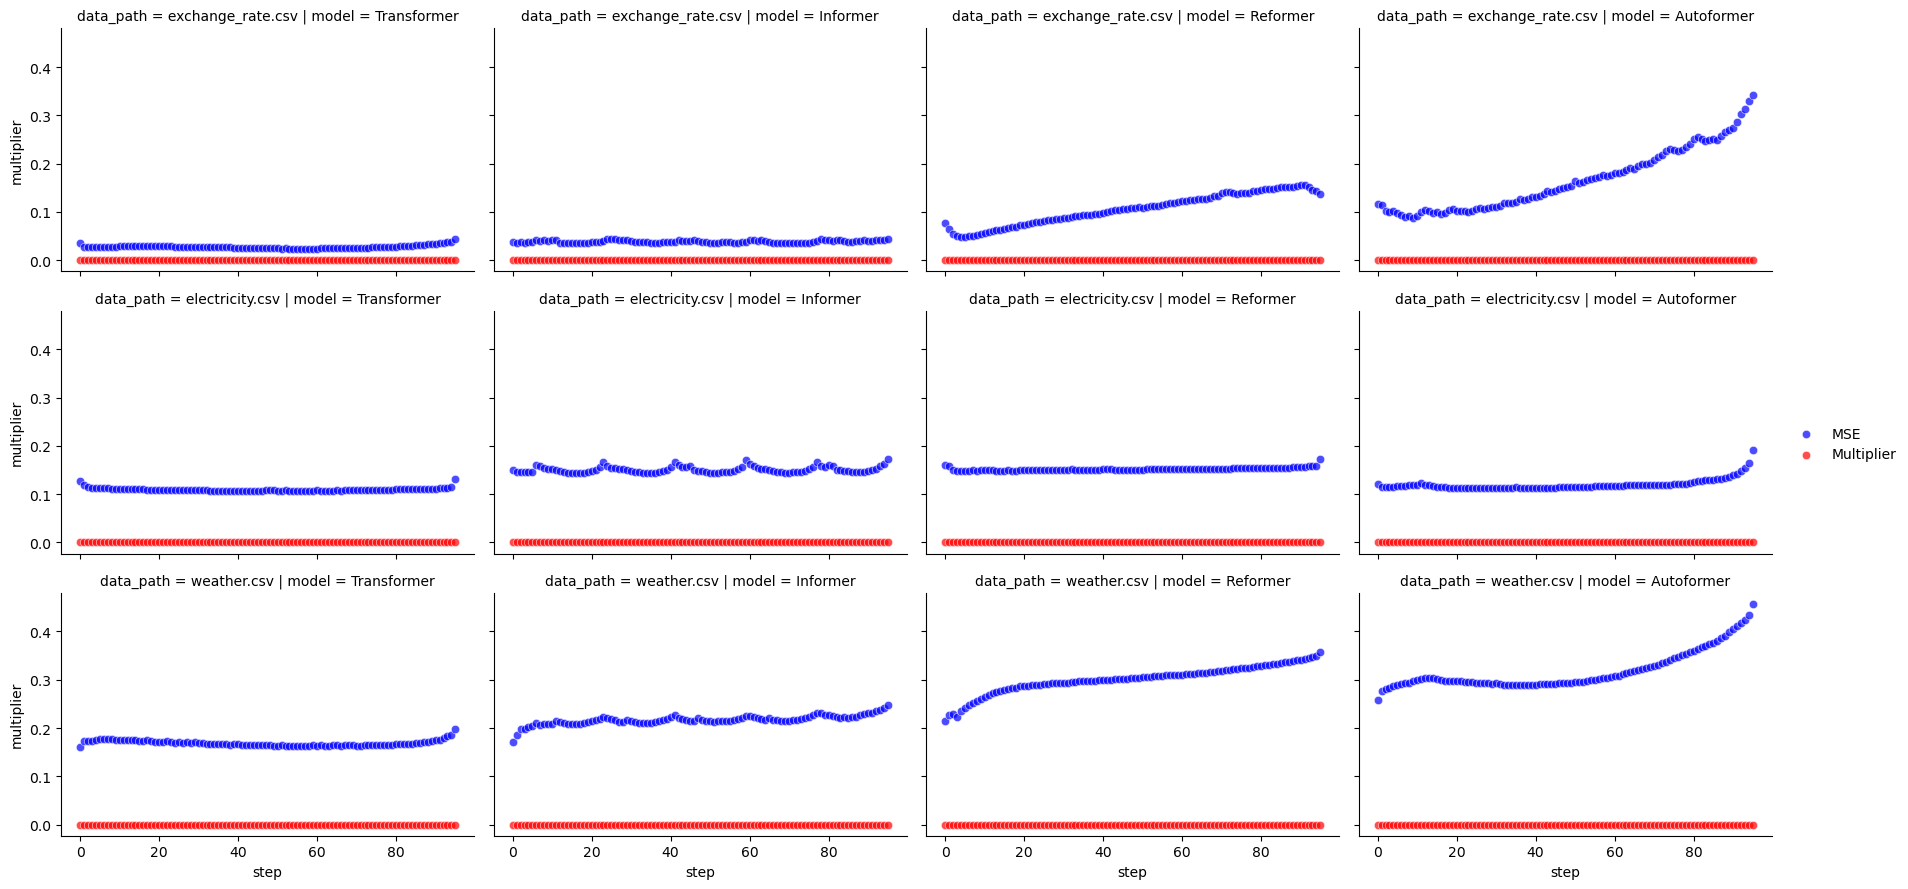

#### **Multipliers vs loss 192 (split=train, constraint_idx=2)**

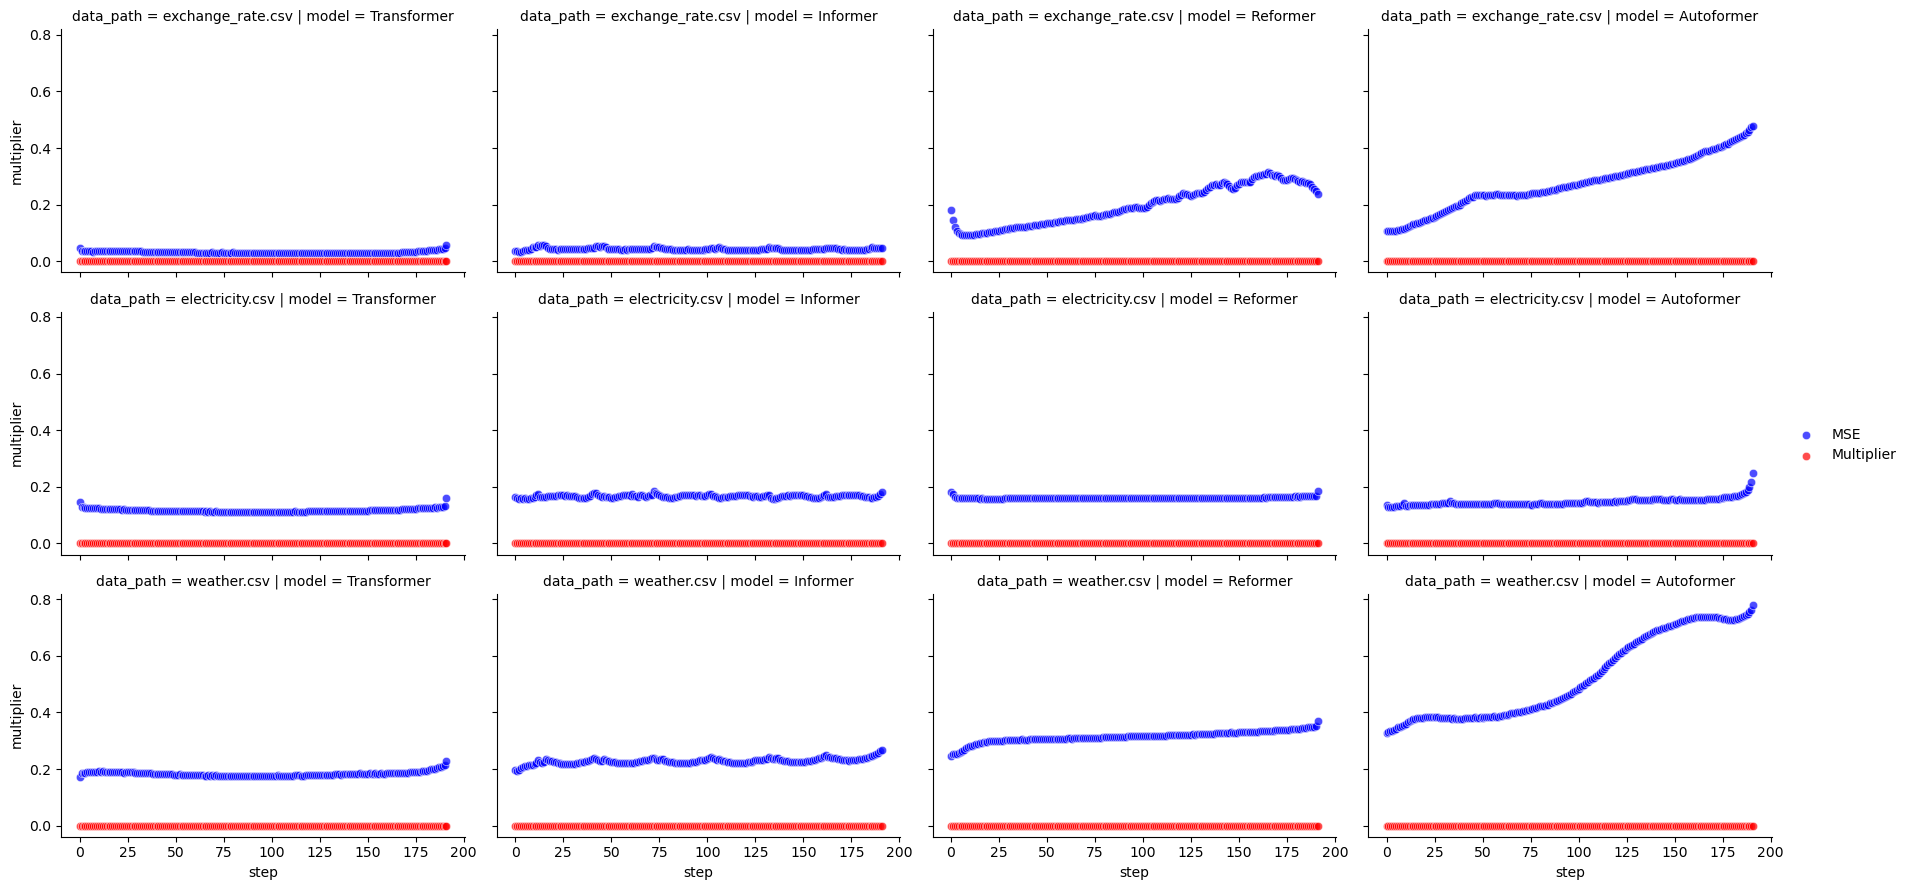

#### **Multipliers vs loss 336 (split=train, constraint_idx=2)**

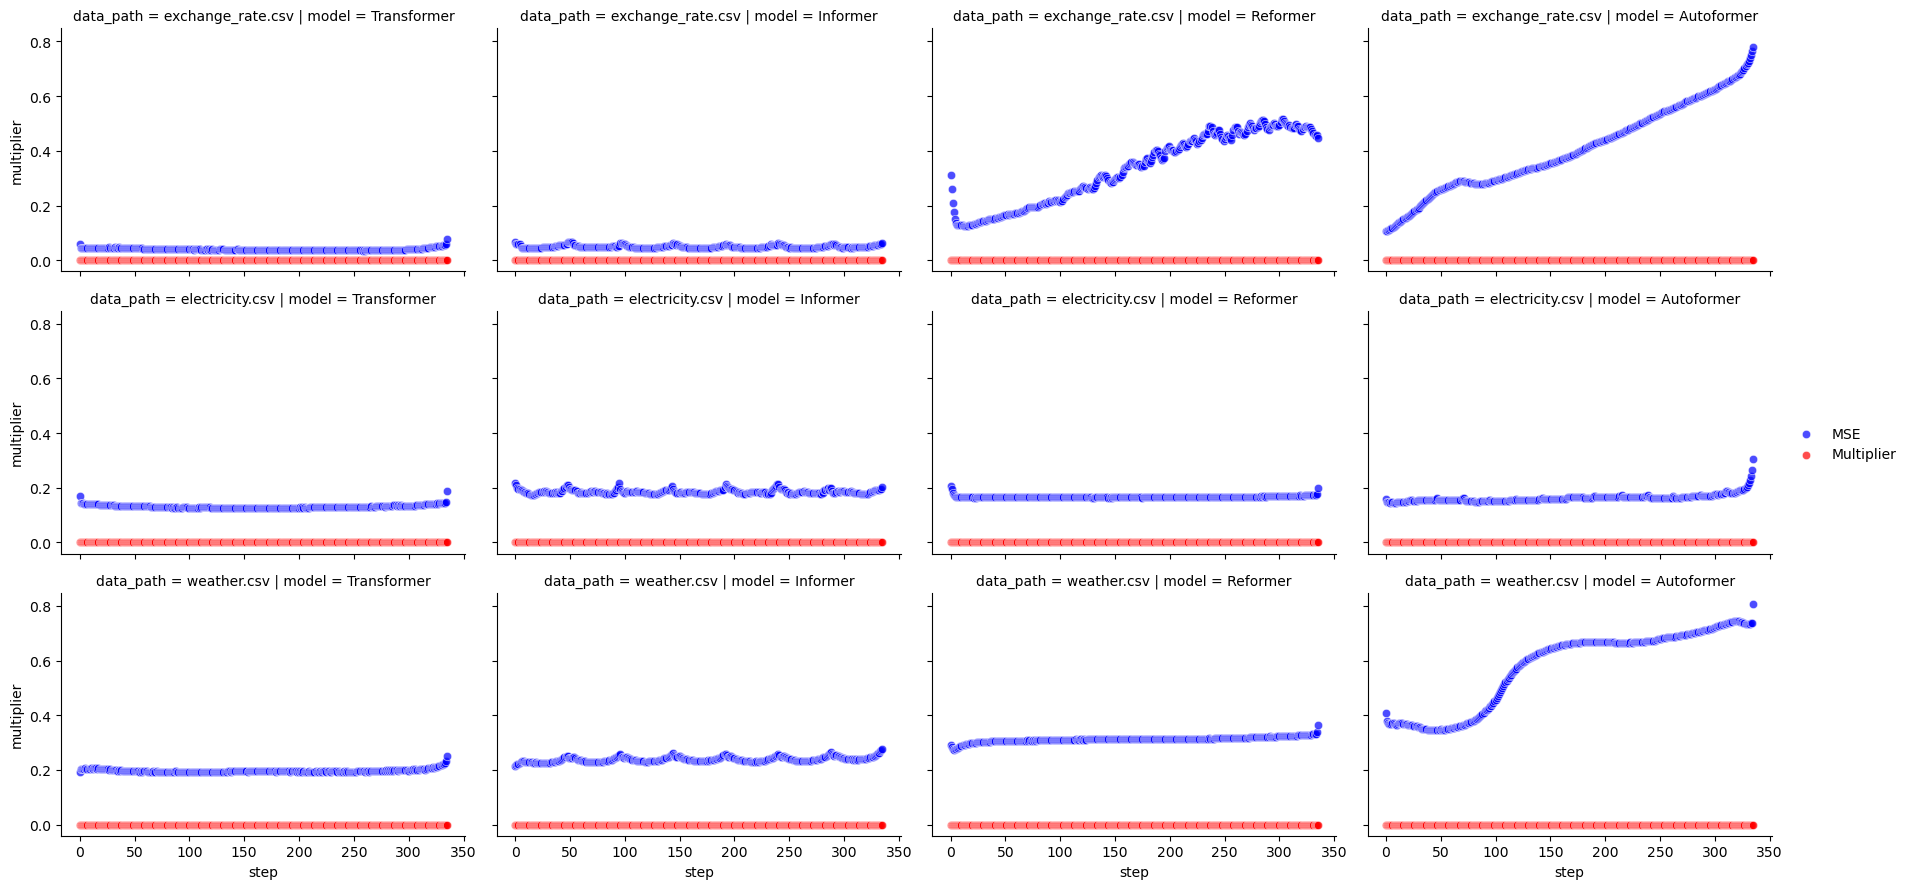

#### **Multipliers vs loss 720 (split=train, constraint_idx=2)**

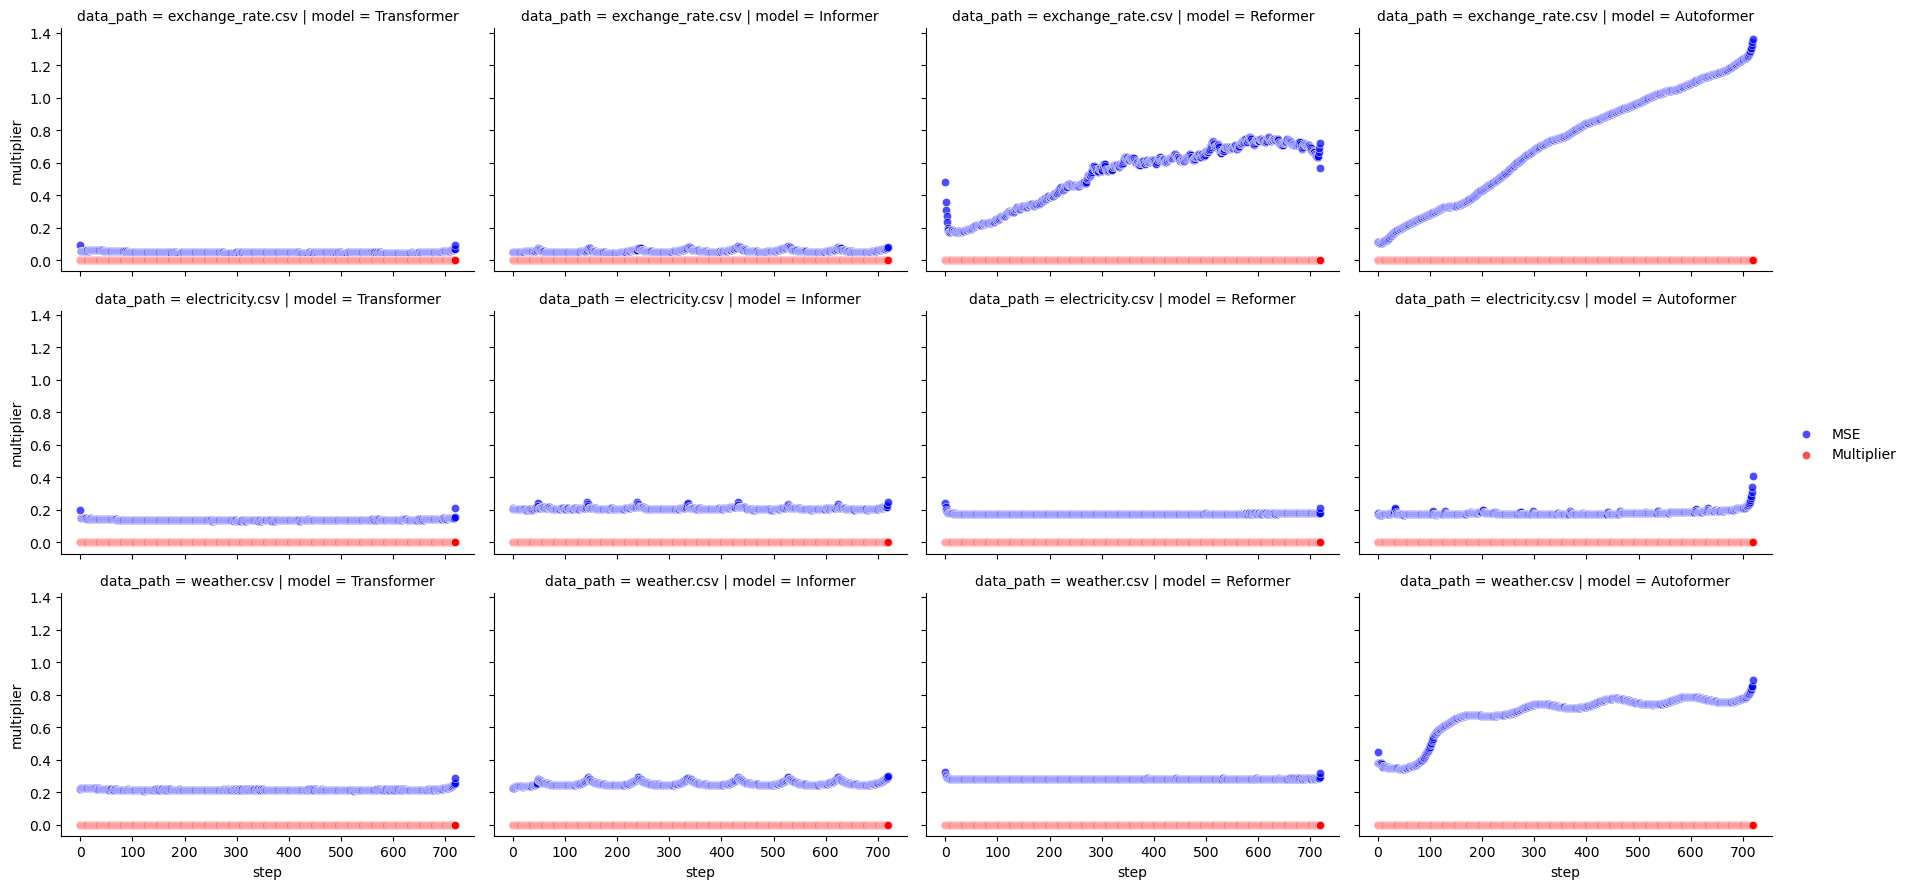

In [24]:
# PARAMS
split="train"
constraint_idx = 2 # use the 50 percentile constraint to plot 1=25,2=50,3=75
seed=2021

# Filter
df_pct50 = df_to_plot[
    (df_to_plot.constraint_idx.isin([0,constraint_idx])) 
    & (df_to_plot.seed==seed) & (df_to_plot.split==split)
    & (df_to_plot.constraint_type==CONSTRAINT_TYPE)
    ].copy()

PRED_LENS=sorted(df_to_plot.pred_len.unique().tolist())
#PRED_LENS=[96]
for pred_len in PRED_LENS:
    # Add data for constant line
    df_current_plot = df_pct50.query('pred_len==@pred_len').copy()
    #constraint_level = df_current_plot.constraint_level.unique()[0]
    #df_current_plot['constraint_level'] = constraint_level
    display(Markdown(f"#### **Multipliers vs loss {pred_len} (split={split}, constraint_idx={constraint_idx})**"))

    g = sns.FacetGrid(df_current_plot, col='model', row='data_path', height=3, aspect=1.5, legend_out=True)
    # Plot multipliers and MSEs
    g.map(sns.scatterplot, "step", "mse", alpha=.7,color='blue',label='MSE')
    g.map(sns.scatterplot, "step", "multiplier", alpha=.7,color='red',label='Multiplier')
    # Add legend the series

    g.add_legend()
    #g.savefig(f"{FIGURES_FOLDER}/constrained_vs_erm_{pred_len}_{str(constraint_level).replace('.','')}.png")
    plt.show()

### Multipliers over training

### Dataset: electricity.csv pred_len: 96

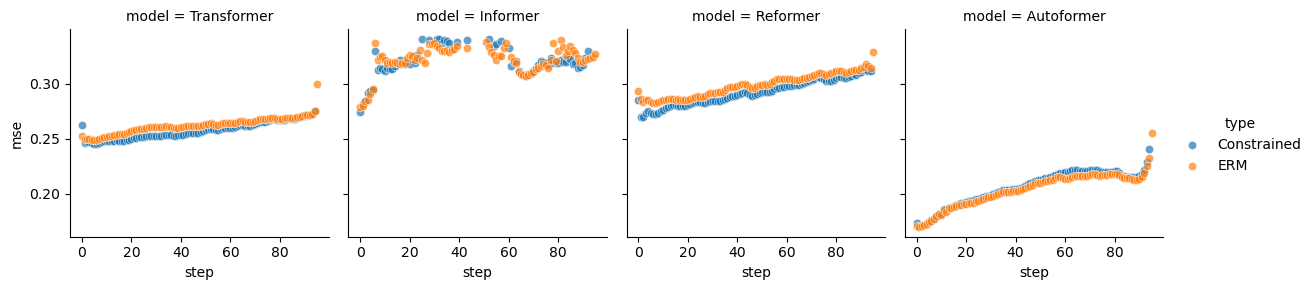

### Dataset: electricity.csv pred_len: 192

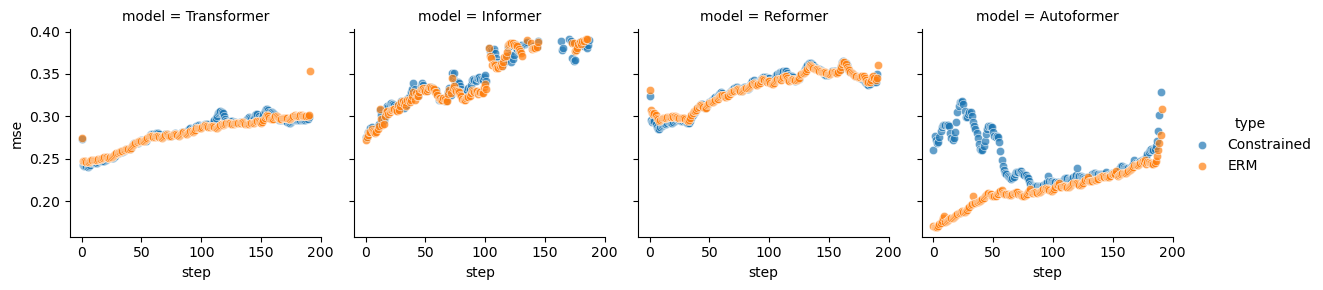

### Dataset: electricity.csv pred_len: 336

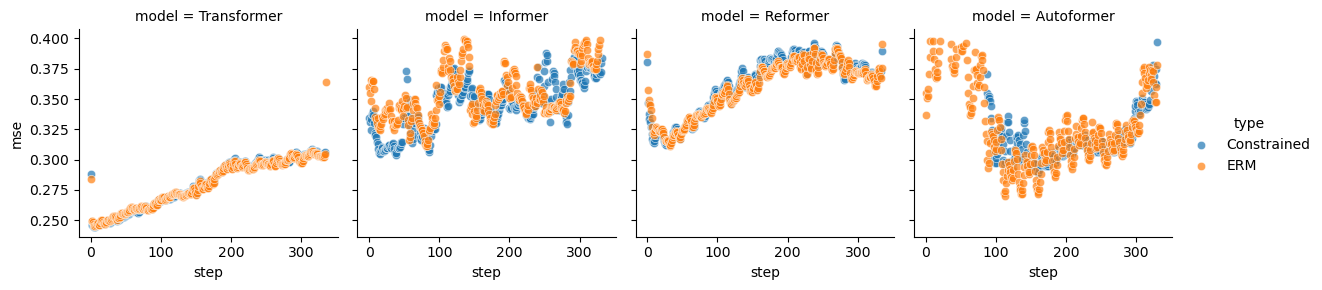

### Dataset: electricity.csv pred_len: 720

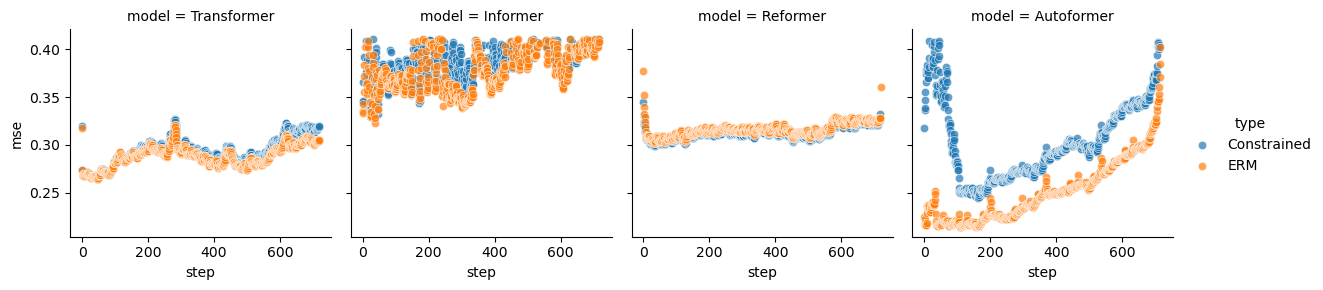

### Dataset: exchange_rate.csv pred_len: 96

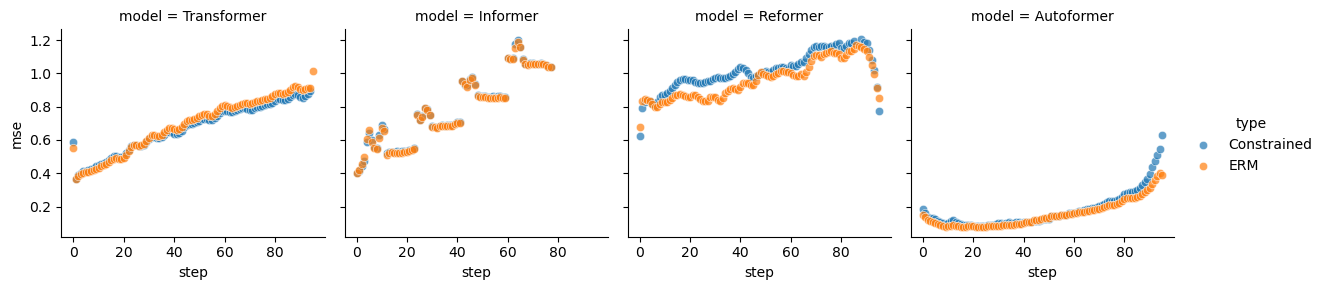

### Dataset: exchange_rate.csv pred_len: 192

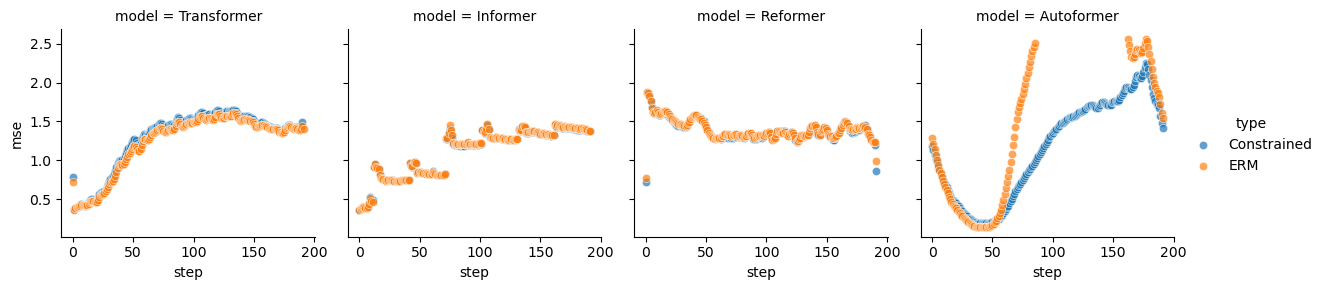

### Dataset: exchange_rate.csv pred_len: 336

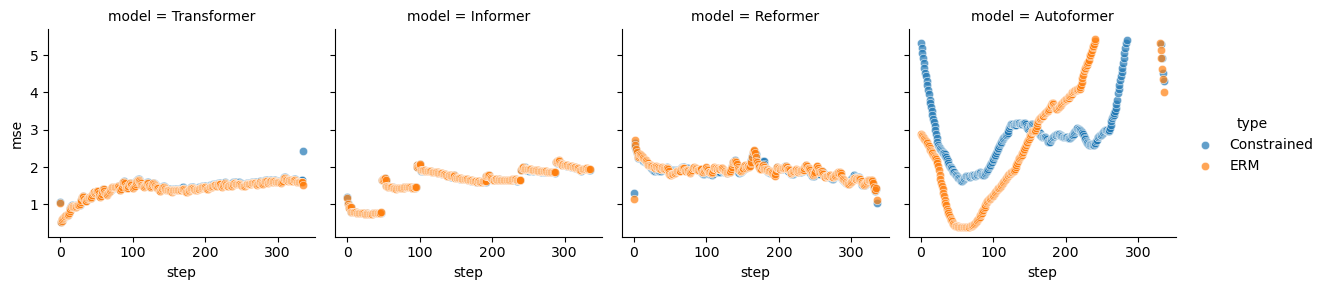

### Dataset: exchange_rate.csv pred_len: 720

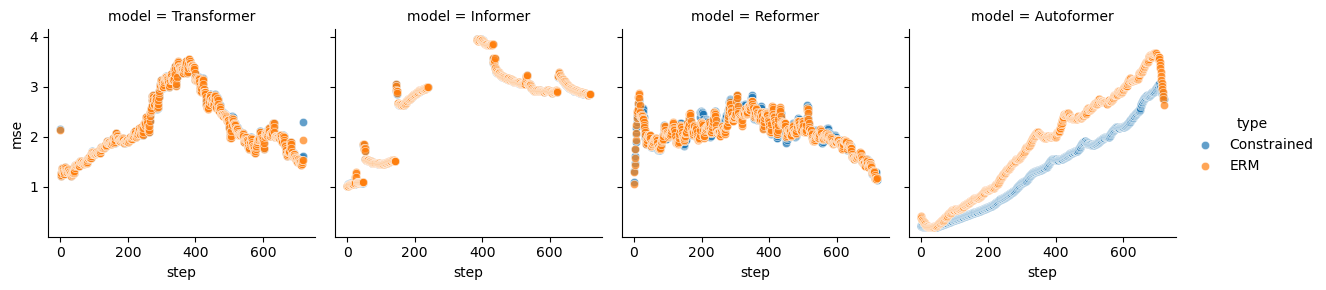

### Dataset: weather.csv pred_len: 96

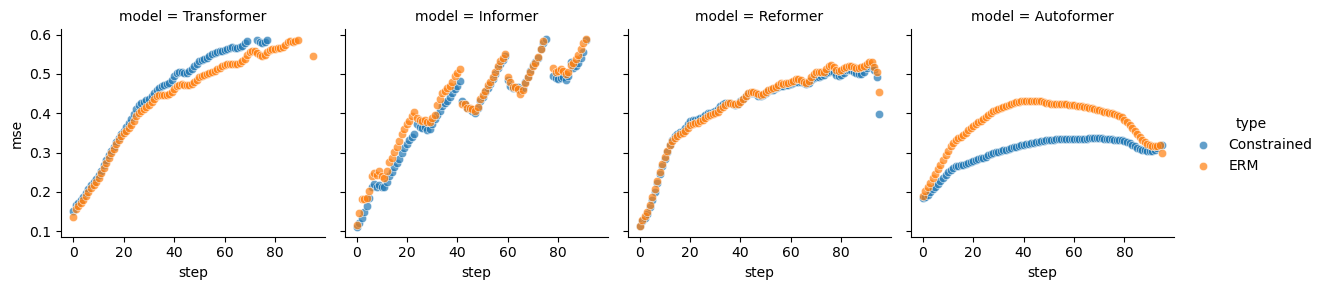

### Dataset: weather.csv pred_len: 192

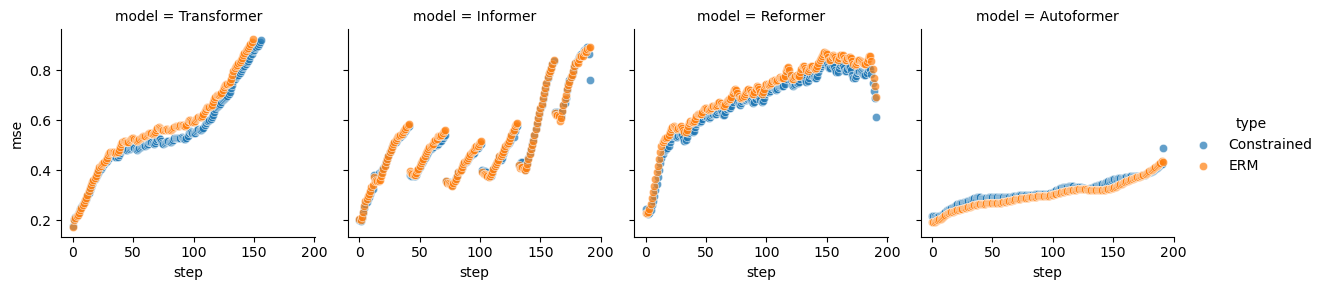

### Dataset: weather.csv pred_len: 336

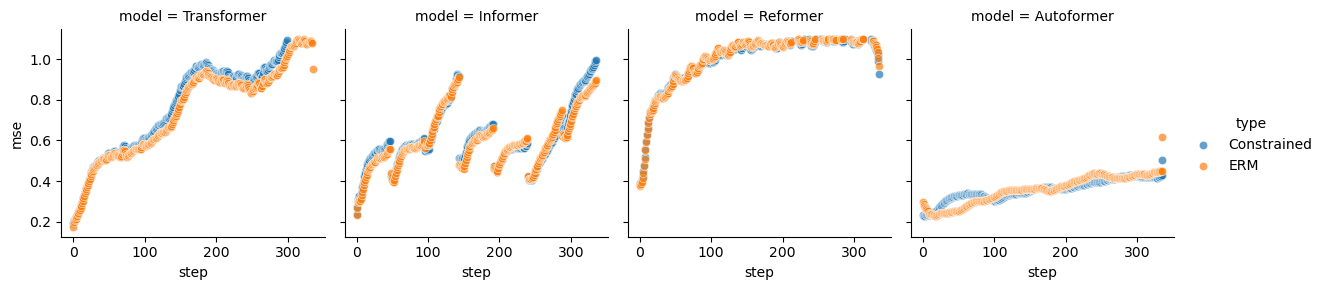

### Dataset: weather.csv pred_len: 720

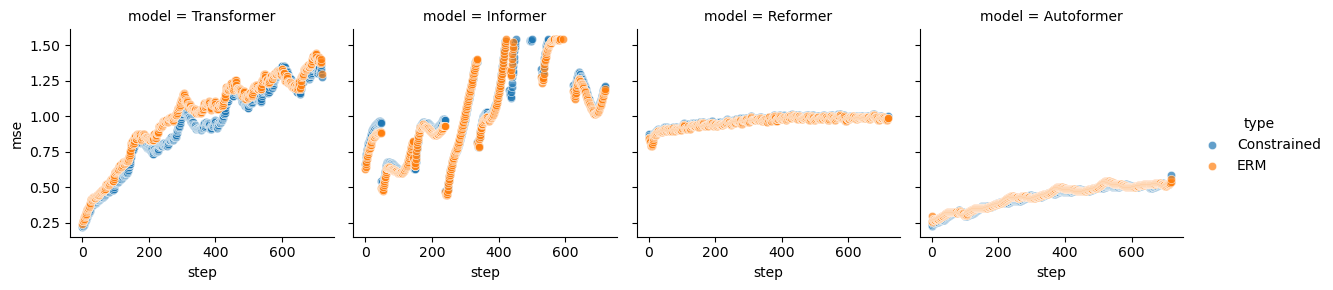

In [39]:
from IPython.display import display, Markdown
to_plot = df_to_plot[(df_to_plot.split=='test')].copy()
for (data_path,pred_len), series in to_plot.groupby(['data_path',"pred_len"]):
    display(Markdown(f"### Dataset: {data_path} pred_len: {pred_len}"))
    # drop outliers in constrained to visualize better (idx=1)
    plot_series = series[series.mse<series.mse.quantile(.95)]
    #plot_series = series#[series["constraint_idx"]==1]
    # This same scatterplot but in a grid by algorithm. 
    g = sns.FacetGrid(plot_series, col="model", hue="type",col_wrap=4)
    g.map(sns.scatterplot, "step", "mse", alpha=.7) 
    g.add_legend()
    plt.show()

### ERM on multiple algorithms
As a front page chart to illustrate the problem

In [ ]:
#TODO ( I think Nacho already did this)

### Loss shaping single instance qualitative analysis

### Plotting dual variables

In [ ]:
df_to_plot[['run_id','pred_len','constraint_level','data_path','model','type']].drop_duplicates().query("data_path=='weather.csv' and model=='Reformer' and type=='Constrained'")

,run_id,pred_len,constraint_level,data_path,model,type
68544,p9izzn2r,96,0.556,weather.csv,Reformer,Constrained
68832,b1adswkj,96,0.553,weather.csv,Reformer,Constrained
69120,dowv2wrc,96,0.516,weather.csv,Reformer,Constrained
69408,i7gx5ivx,192,0.665,weather.csv,Reformer,Constrained
69984,v4rwuch4,192,0.567,weather.csv,Reformer,Constrained
70560,mitm69y2,192,0.553,weather.csv,Reformer,Constrained
71136,chbkcq99,336,0.970,weather.csv,Reformer,Constrained
72144,749ywu49,336,0.741,weather.csv,Reformer,Constrained
73152,fe29o3il,336,0.682,weather.csv,Reformer,Constrained
74160,n1dluqy8,720,0.912,weather.csv,Reformer,Constrained


In [ ]:
constrained_runs = df_to_plot.query('type=="Constrained"').copy()
# Sum the multilpiers, fill with 0
key_cols=['run_id','model','pred_len','constraint_level','data_path']
multiplier_sum=constrained_runs.groupby(key_cols)['multiplier'].sum().reset_index()

#TO DO: plot MSE 
# get test mse
test_mses=constrained_runs.query('split=="test"').groupby(key_cols)['mse'].mean().reset_index()
mult_vs_test_mse=multiplier_sum.merge(test_mses,on=key_cols)
#sns.scatterplot(x="multiplier", y="mse", hue="constraint_level",style="pred_len", data=mult_vs_test_mse)
#g = sns.FacetGrid(mult_vs_test_mse, col="model",row='data_path',style="pred_len")
# scatterplot with hue="constraint_level",style="pred_len"
#g.map(sns.scatterplot, "multiplier", "mse", alpha=.7,)#sns.scatterplot(**args,hue="constraint_level",style="pred_len",alpha=0.3)
#g.map(sns.scatterplot, "multiplier", "mse",alpha=.7)

In [ ]:
# #df_to_plot.query('split=="train" and pred_len==96').run_id.head(1)
# #mult_cols = [f"multiplier/{i}" for i in range(0,96)]
# # Plot for every constraint level in the 96 pred len window
# #for pred_len in df_to_plot.pred_len.unique():
# display(Markdown(f"# Multipliers for window of {pred_len}"))
# # sns.scatterplot(x="step", y="multiplier", hue="model",style="constraint_level", 
# #     data=df_to_plot.query(f"split=='train' and type=='Constrained' and pred_len=={96} and data_path=='weather.csv'"))
# # same plot, but grid with one plot per model
# dd = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='train'")#.query(f"split=='train' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")
# dd_test = df_to_plot#df_to_plot.query("run_id=='6fgam2dx' and split=='test'")#.query(f"split=='test' and type=='Constrained' and pred_len==96 and data_path=='electricity.csv' and model=='Reformer' and constraint_level==0.157")

# #print(dd_test.constraint_level.unique())
# test_set_plus_multipliers = dd[['step','multiplier']].merge(dd_test[['step','split','mse']],on='step')

# unioned = pd.concat([dd[['step','split','multiplier','mse']],test_set_plus_multipliers[['step','split','multiplier','mse']]])

# display(unioned)


# display(test_set_plus_multipliers)

# #constraint_level==0.553
# # mult on x, mse@train and mse@test on y. hue=split
# # Add step over every point
# sns.scatterplot(unioned,x="multiplier", y="mse",hue='split', alpha=.3,legend='full')



# g = sns.FacetGrid(dd, col="model", row="constraint_level")
# g.map(sns.scatterplot, "step", "multiplier", alpha=.3)
# #g.map(sns.scatterplot, "step", "mse", alpha=.3)

# Multipliers for window of 720

,step,split,multiplier,mse
16128,0,train,2.801533,0.209369
16129,1,train,1.050123,0.204042
16130,2,train,0.269966,0.194581
16131,3,train,0.000000,0.189056
16132,4,train,0.000000,0.187635
...,...,...,...,...
17418235,719,test,NaN,1.910884
17418236,719,test,NaN,1.910884
17418237,719,val,NaN,1.909591
17418238,719,val,NaN,1.909591


,step,multiplier,split,mse
0,0,2.801533,train,0.209369
1,0,2.801533,test,0.268508
2,0,2.801533,val,0.266284
3,0,2.801533,train,0.215619
4,0,2.801533,test,0.247226
...,...,...,...,...
17418235,719,NaN,test,1.910884
17418236,719,NaN,test,1.910884
17418237,719,NaN,val,1.909591
17418238,719,NaN,val,1.909591


Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fedbc19fa70> (for post_execute):


KeyboardInterrupt: 

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7fedbc19f4d0> (for post_execute):


KeyboardInterrupt: 

### More random explorations
Ideas: 
1. Loss over time
2. Infeasibility rate over time
3. Loss shape across epochs (see how it evolves)
4. Plotting dual variables

## Result tables
1. Reproduce the pivot table from notebook 11, perhaps add standard deviation reports.
2. Explore and find other interesting table visualziation

### Pivot tables (summary)

In [19]:
#Note, variance is nan because there is only one run per parameter set
weather = summary_metrics.query('data_path=="weather.csv"').copy()
electricity = summary_metrics.query('data_path=="electricity.csv"').copy()
for name,dataset in [('weather',weather), ('electricity',electricity)]:
    display(Markdown(f"# {name}"))
    tp2=dataset.copy(deep=True)
    #tp2=weather.query('split=="test"').copy()
    # Compute 'infeasible amount' as the difference between the mse and the constraint_level, 0 if mse < constraint
    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)
    
    # Split into constrained and ERM
    tp2_constrained=tp2.query('type=="Constrained"').copy()
    tp2_erm_baseline=tp2.query('type=="ERM"').copy()

    distinct_constraints = tp2_constrained[['pred_len','model','constraint_level']].drop_duplicates()

    # crossjoin the ERM mse to all constraint levels
    #tp2_erm_baseline_broadcasted = tp2_erm_baseline.drop(columns=['constraint_level']).merge(distinct_constraints,on=['pred_len','model'],how='left')

    #display(tp2_erm_baseline_broadcasted[['type','model','constraint_level','mse']].head())

    # concat back together to compute mean_violation
    #tp2=pd.concat([tp2_constrained,tp2_erm_baseline_broadcasted],axis=0)

    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)

    # Sanity check show the mean_violation for the ERM runs
    #display(tp2.query('type=="ERM"')[['type','model','constraint_level','mse','mean_violation']].head())


    #GROUPING TEH VALS
    grouped_values=tp2.groupby(['pred_len','constraint_level','model','type'])[[
        'mse','mcv',
        'std_mse','std_mcv',
        'mean_infeasible_rate','std_infeasible_rate']].mean().reset_index()
    #grouped_constrained = grouped_values[grouped_values.type=='Constrained'].copy()
    #grouped_erm_baseline=grouped_values[grouped_values.type=='ERM'].copy()

    # best_constraints is the constraint for each model and pred_len that minimizes mean_violation. show min and argmin
    #best_constraints_per_window = grouped_values.query('type=="Constrained"').groupby(['pred_len']).apply(lambda x: x.loc[x['mean_violation'].idxmin()]).reset_index(drop=True)[['pred_len','type','constraint_level','mean_violation','mse']]
    # instead of best constraints, show all constraint levels.

    # join best_constraints and grouped_values to get the mse and mean_violation for the best constraint
    #best_constrained=grouped_values.merge(best_constraints_per_window[['pred_len','constraint_level']],on=['pred_len','constraint_level'],how='inner')


    # crossjoin the ERM mse to all constraint levels
    ##grouped_erm_baseline_broadcasted = grouped_erm_baseline.drop(columns=['constraint_level']).merge(grouped_constrained[['pred_len','model','constraint_level']].drop_duplicates(),on=['pred_len','model'],how='left')

    # Pivot of models versus constrained and ERM, values are mse and mse_diff
    all_results = grouped_values#pd.concat([grouped_constrained,grouped_erm_baseline_broadcasted],axis=0)
    # Pivot all results, sort ascending by pred_len, then mean_violation on constrained

    pivoted=all_results.pivot(
        index=['pred_len','constraint_level'], 
        columns=['type','model'], 
        values=['mse','std_mse','mcv','std_mcv','mean_infeasible_rate','std_infeasible_rate']
    ).query('constraint_level>0').round(4)
    simplified = all_results.pivot(
        index=['pred_len','constraint_level'],
        columns=['type','model'],
        values=['mse','mcv']
    )
    pd.set_option('display.max_columns', None)
    print("SIMPLIFIED 192 MSE")
    # show all pred lengths (index)
    for pred_len in [96, 192, 336, 720]:            
        print(simplified.index.get_level_values(0).unique())
        simp_mse_192=simplified[simplified.index.get_level_values(0)==pred_len][['mse']]
        sim_mcv_192=simplified[simplified.index.get_level_values(0)==pred_len][['mcv']]

        # Flatten the multiindex
        def prettify(d):
            d = d.copy()
            d.columns = d.columns.map('_'.join)
            return d.style.format(precision=3)
        # display(prettify(simp_mse_192))
        print(f"SIMPLIFIED {pred_len} MCV")
        display(prettify(sim_mcv_192))
    print("FULL")
    display(pivoted)
    #reformer works best on weather.

# weather

SIMPLIFIED 192 MSE
Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 96 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 192 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 336 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 720 MCV


FULL


mse                                   \
type                      Constrained         ERM Constrained      ERM   
model                     Transformer Transformer    Informer Informer   
pred_len constraint_level                                                
96       0.467                 0.3932      0.3776         NaN      NaN   
         0.475                    NaN         NaN      0.3998   0.3836   
         0.484                    NaN         NaN         NaN      NaN   
         0.527                    NaN         NaN      0.4074   0.3836   
         0.538                 0.3869      0.3776         NaN      NaN   
         0.548                    NaN         NaN      0.3992   0.3836   
         0.549                    NaN         NaN         NaN      NaN   
         0.565                    NaN         NaN         NaN      NaN   
         0.585                 0.3870      0.3776         NaN      NaN   
192      0.525                    NaN         NaN      0.4409   0.4364   
         0.559                 0.5479      0.5017         NaN      NaN   
         0.563                    NaN         NaN      0.4270   0.4364   
         0.580                    NaN         NaN         NaN      NaN   
         0.598                    NaN         NaN         NaN      NaN   
         0.607                    NaN         NaN      0.4409   0.4364   
         0.627                    NaN         NaN         NaN      NaN   
         0.662                 0.5888      0.5017         NaN      NaN   
         0.667                    NaN         NaN         NaN      NaN   
         0.771                 0.5986      0.5017         NaN      NaN   
336      0.577                    NaN         NaN      0.5294   0.4980   
         0.610                    NaN         NaN         NaN      NaN   
         0.622                 0.6319      0.5636         NaN      NaN   
         0.671                    NaN         NaN      0.5439   0.4980   
         0.679                    NaN         NaN         NaN      NaN   
         0.729                    NaN         NaN      0.5609   0.4980   
         0.730                    NaN         NaN         NaN      NaN   
         0.772                 0.6517      0.5636         NaN      NaN   
         0.804                    NaN         NaN         NaN      NaN   
         0.835                    NaN         NaN         NaN      NaN   
         0.869                 0.6517      0.5636         NaN      NaN   
720      0.747                    NaN         NaN      1.0187   0.7342   
         0.787                 0.8727      0.7018         NaN      NaN   
         0.849                    NaN         NaN      1.0665   0.7342   
         0.877                    NaN         NaN         NaN      NaN   
         0.892                    NaN         NaN         NaN      NaN   
         0.905                    NaN         NaN         NaN      NaN   
         0.972                 0.8927      0.7018         NaN      NaN   
         0.980                    NaN         NaN      1.0985   0.7342   
         1.035                 0.8925      0.7018         NaN      NaN   

                                                                       \
type                      Constrained        ERM Constrained      ERM   
model                      Autoformer Autoformer    Reformer Reformer   
pred_len constraint_level                                               
96       0.467                    NaN        NaN         NaN      NaN   
         0.475                    NaN        NaN         NaN      NaN   
         0.484                 0.4088     0.4086         NaN      NaN   
         0.527                    NaN        NaN      0.3965   0.4053   
         0.538                    NaN        NaN         NaN      NaN   
         0.548                    NaN        NaN         NaN      NaN   
         0.549                 0.4010     0.4086         NaN      NaN   
         0.565                    NaN        NaN

# electricity

SIMPLIFIED 192 MSE
Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 96 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 192 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 336 MCV


Int64Index([96, 192, 336, 720], dtype='int64', name='pred_len')
SIMPLIFIED 720 MCV


FULL


mse                                     \
type                      Constrained        ERM Constrained         ERM   
model                      Autoformer Autoformer Transformer Transformer   
pred_len constraint_level                                                  
96       0.151                 0.1607     0.1618         NaN         NaN   
         0.160                 0.1639     0.1618         NaN         NaN   
         0.166                 0.1646     0.1618         NaN         NaN   
         0.176                    NaN        NaN      0.1866      0.1852   
         0.181                    NaN        NaN      0.1870      0.1852   
         0.189                    NaN        NaN      0.1879      0.1852   
         0.198                    NaN        NaN         NaN         NaN   
         0.202                    NaN        NaN         NaN         NaN   
         0.207                    NaN        NaN         NaN         NaN   
         0.224                    NaN        NaN         NaN         NaN   
         0.226                    NaN        NaN         NaN         NaN   
         0.232                    NaN        NaN         NaN         NaN   
192      0.174                 0.1857     0.1797         NaN         NaN   
         0.184                 0.1917     0.1797         NaN         NaN   
         0.197                    NaN        NaN      0.2029      0.2020   
         0.202                 0.1880     0.1797         NaN         NaN   
         0.211                    NaN        NaN      0.2026      0.2020   
         0.218                    NaN        NaN         NaN         NaN   
         0.226                    NaN        NaN         NaN         NaN   
         0.227                    NaN        NaN      0.2090      0.2020   
         0.237                    NaN        NaN         NaN         NaN   
         0.238                    NaN        NaN         NaN         NaN   
         0.254                    NaN        NaN         NaN         NaN   
         0.257                    NaN        NaN         NaN         NaN   
336      0.194                    NaN        NaN      0.2105      0.2093   
         0.197                 0.1954     0.2352         NaN         NaN   
         0.207                 0.1992     0.2352         NaN         NaN   
         0.211                    NaN        NaN      0.2146      0.2093   
         0.223                    NaN        NaN         NaN         NaN   
         0.234                    NaN        NaN      0.2171      0.2093   
         0.236                    NaN        NaN         NaN         NaN   
         0.240                 0.1981     0.2352         NaN         NaN   
         0.250                    NaN        NaN         NaN         NaN   
         0.254                    NaN        NaN         NaN         NaN   
         0.263                    NaN        NaN         NaN         NaN   
         0.296                    NaN        NaN         NaN         NaN   
720      0.218                 0.2910     0.2171         NaN         NaN   
         0.228                 0.2663     0.2171         NaN         NaN   
         0.232                    NaN        NaN      0.2332      0.2255   
         0.239                    NaN        NaN      0.2346      0.2255   
         0.244                 0.2521     0.2171         NaN         NaN   
         0.250                    NaN        NaN      0.2368      0.2255   
         0.251                    NaN        NaN         NaN         NaN   
         0.254                    NaN        NaN         NaN         NaN   
         0.255                    NaN        NaN         NaN         NaN   
         0.309                    NaN        NaN         NaN         NaN   
         0.321                    NaN        NaN         NaN         NaN   
         0.352                    NaN        NaN         NaN         NaN   

                                                                     \
type      

### Comparing variance and CoV ERM vs constrained

In [21]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240 entries, 288 to 815
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Algorithm             240 non-null    object 
 1   model                 240 non-null    object 
 2   type                  240 non-null    object 
 3   constraint_level      240 non-null    float64
 4   pred_len              240 non-null    int64  
 5   data_path             240 non-null    object 
 6   split                 240 non-null    object 
 7   mse                   240 non-null    float64
 8   std_mse               0 non-null      float64
 9   mcv                   240 non-null    float64
 10  std_mcv               0 non-null      float64
 11  mean_infeasible_rate  240 non-null    float64
 12  std_infeasible_rate   0 non-null      float64
 13  run_count             240 non-null    float64
dtypes: float64(8), int64(1), object(5)
memory usage: 28.1+ KB


In [50]:
df_to_plot.query("split=='test'").constraint_idx.unique()

array([3, 2, 1, 0])

In [59]:
# Calculate mean and std for mse and constraint_violation. Rename them mean_{metric} and std_{metric
#ToDO filter one seeed and split
stepwise_metrics = df_to_plot[df_to_plot.constraint_idx.isin([0,2])].query("split=='test'").groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",'type',
    "constraint_level",
    "constraint_idx",
    "pred_len",
    "data_path",
    "split",
    'step'#STEPWISE
    ])['mse','constraint_violation','infeasible_rate','run_id'].aggregate(
        mse=('mse','mean'),
        #std_mse=('mse','std'),
        mcv=('constraint_violation','mean'),
        #std_mcv=('constraint_violation','std'),
        mean_infeasible_rate=('infeasible_rate','mean'),
        #std_infeasible_rate=('infeasible_rate','std'),
        run_count=('run_id','nunique')
        ).reset_index().round(5)
summary_stepwise=stepwise_metrics.groupby([
    "run_id",
    "Algorithm", #Harmless carryover col for legacy purposes (verified the counts are the same)
    "model",
    'type',
    "constraint_level",
    "constraint_idx",
    "pred_len",
    "data_path",
    "split"]).aggregate(
        mse=('mse','mean'),
        std_mse=('mse','std'),
        mcv=('mcv','mean'),
        std_mcv=('mcv','std'),
        mean_infeasible_rate=('mean_infeasible_rate','mean'),
        std_infeasible_rate=('mean_infeasible_rate','std'),
        run_count=('run_count','mean'),
        step_count=('step','count')
    ).reset_index()
summary_stepwise

/home/jporras/miniconda3/envs/autoformer/lib/python3.7/site-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]


,run_id,Algorithm,model,type,constraint_level,constraint_idx,pred_len,data_path,split,mse,std_mse,mcv,std_mcv,mean_infeasible_rate,std_infeasible_rate,run_count,step_count
0,02zvd69l,exchange_rate Transformer,Transformer,Constrained,0.798,2,192,exchange_rate.csv,test,1.078070,0.283924,0.317347,0.222823,0.78976,0.0,1.0,192
1,07srnmcx,exchange_rate Autoformer,Autoformer,Constrained,1.047,2,720,exchange_rate.csv,test,0.982165,0.129014,0.024493,0.065788,0.32604,0.0,1.0,720
2,092u33lj,AllModels_electricity.csv Reformer,Reformer,ERM,0.198,0,96,electricity.csv,test,0.298882,0.010611,0.100882,0.010611,1.00000,0.0,1.0,96
3,092u33lj,AllModels_electricity.csv Reformer,Reformer,ERM,0.202,0,96,electricity.csv,test,0.298882,0.010611,0.096882,0.010611,1.00000,0.0,1.0,96
4,092u33lj,AllModels_electricity.csv Reformer,Reformer,ERM,0.207,0,96,electricity.csv,test,0.298882,0.010611,0.091882,0.010611,1.00000,0.0,1.0,96
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,yhsan1ax,AllModels_weather.csv Informer,Informer,ERM,0.607,0,192,weather.csv,test,0.514648,0.158067,0.034075,0.077200,1.00000,0.0,1.0,192
178,z46h4r20,electricity Autoformer,Autoformer,Constrained,0.228,2,720,electricity.csv,test,0.375928,0.253698,0.147928,0.253698,0.95283,0.0,1.0,720
179,zuqz5thy,AllModels_exchange_rate.csv Reformer,Reformer,ERM,1.137,0,96,exchange_rate.csv,test,0.960433,0.115636,0.001075,0.005120,1.00000,0.0,1.0,96
180,zuqz5thy,AllModels_exchange_rate.csv Reformer,Reformer,ERM,1.221,0,96,exchange_rate.csv,test,0.960433,0.115636,0.000000,0.000000,1.00000,0.0,1.0,96


In [105]:
summary_stepwise.groupby(['run_id','type','constraint_idx',"Algorithm","model"]).size().reset_index()

,run_id,type,constraint_idx,Algorithm,model,0
0,02zvd69l,Constrained,2,exchange_rate Transformer,Transformer,1
1,07srnmcx,Constrained,2,exchange_rate Autoformer,Autoformer,1
2,092u33lj,ERM,0,AllModels_electricity.csv Reformer,Reformer,3
3,0roswz2a,ERM,0,AllModels_electricity.csv Autoformer,Autoformer,3
4,0uvkl0hn,Constrained,2,exchange_rate Reformer,Reformer,1
...,...,...,...,...,...,...
88,xyee0xef,Constrained,2,weather Informer,Informer,1
89,y7ygu53t,Constrained,2,exchange_rate Autoformer,Autoformer,1
90,yhsan1ax,ERM,0,AllModels_weather.csv Informer,Informer,3
91,z46h4r20,Constrained,2,electricity Autoformer,Autoformer,1


In [104]:
dd_weather = summary_stepwise.query('data_path=="weather.csv" and pred_len==96').copy()
dd_weather.groupby(['run_id','constraint_idx',"Algorithm","model","constraint_idx"])
#dd_weather.pivot(index=['run_id','constraint_idx',"Algorithm","model","constraint_idx"], columns='type', values='mse')

#### Pivot tables stepwise

In [53]:
#Note, variance is nan because there is only one run per parameter set
weather = summary_stepwise.query('data_path=="weather.csv"').copy()
electricity = summary_stepwise.query('data_path=="electricity.csv"').copy()
for name,dataset in [('weather',weather), ('electricity',electricity)]:
    display(Markdown(f"# {name}"))
    tp2=dataset.copy(deep=True)
    #tp2=weather.query('split=="test"').copy()
    # Compute 'infeasible amount' as the difference between the mse and the constraint_level, 0 if mse < constraint
    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)
    
    # Split into constrained and ERM
    tp2_constrained=tp2.query('type=="Constrained"').copy()
    tp2_erm_baseline=tp2.query('type=="ERM"').copy()

    distinct_constraints = tp2_constrained[['pred_len','model','constraint_level']].drop_duplicates()

    # crossjoin the ERM mse to all constraint levels
    #tp2_erm_baseline_broadcasted = tp2_erm_baseline.drop(columns=['constraint_level']).merge(distinct_constraints,on=['pred_len','model'],how='left')

    #display(tp2_erm_baseline_broadcasted[['type','model','constraint_level','mse']].head())

    # concat back together to compute mean_violation
    #tp2=pd.concat([tp2_constrained,tp2_erm_baseline_broadcasted],axis=0)

    #tp2['mean_violation']=tp2.apply(lambda x: max(0,x['mse']-x['constraint_level']),axis=1)

    # Sanity check show the mean_violation for the ERM runs
    #display(tp2.query('type=="ERM"')[['type','model','constraint_level','mse','mean_violation']].head())


    #GROUPING TEH VALS
    grouped_values=tp2.groupby(['pred_len','constraint_level','constraint_idx','model','type'])[[
        'mse','mcv',
        'std_mse','std_mcv',
        'mean_infeasible_rate','std_infeasible_rate']].mean().reset_index()
    #grouped_constrained = grouped_values[grouped_values.type=='Constrained'].copy()
    #grouped_erm_baseline=grouped_values[grouped_values.type=='ERM'].copy()

    # best_constraints is the constraint for each model and pred_len that minimizes mean_violation. show min and argmin
    #best_constraints_per_window = grouped_values.query('type=="Constrained"').groupby(['pred_len']).apply(lambda x: x.loc[x['mean_violation'].idxmin()]).reset_index(drop=True)[['pred_len','type','constraint_level','mean_violation','mse']]
    # instead of best constraints, show all constraint levels.

    # join best_constraints and grouped_values to get the mse and mean_violation for the best constraint
    #best_constrained=grouped_values.merge(best_constraints_per_window[['pred_len','constraint_level']],on=['pred_len','constraint_level'],how='inner')


    # crossjoin the ERM mse to all constraint levels
    ##grouped_erm_baseline_broadcasted = grouped_erm_baseline.drop(columns=['constraint_level']).merge(grouped_constrained[['pred_len','model','constraint_level']].drop_duplicates(),on=['pred_len','model'],how='left')

    # Pivot of models versus constrained and ERM, values are mse and mse_diff
    all_results = grouped_values#pd.concat([grouped_constrained,grouped_erm_baseline_broadcasted],axis=0)
    # Pivot all results, sort ascending by pred_len, then mean_violation on constrained

    pivoted=all_results.pivot(
        index=['pred_len','constraint_idx'], 
        columns=['type','model'],
        values=['mse','std_mse','mcv','std_mcv','mean_infeasible_rate','std_infeasible_rate']
    ).query('constraint_level>0').round(4)
    simplified = all_results.pivot(
        index=['pred_len','constraint_level'],
        columns=['type','model'],
        values=['mse','mcv']
    )
    pd.set_option('display.max_columns', None)
    print("SIMPLIFIED 192 MSE")
    # show all pred lengths (index)
    for pred_len in [96, 192, 336, 720]:    
        print(simplified.index.get_level_values(0).unique())
        simp_mse_192=simplified[simplified.index.get_level_values(0)==pred_len][['mse']]
        sim_mcv_192=simplified[simplified.index.get_level_values(0)==pred_len][['mcv']]

        # Flatten the multiindex
        def prettify(d):
            d = d.copy()
            d.columns = d.columns.map('_'.join)
            return d.style.format(precision=3)
        # display(prettify(simp_mse_192))
        print(f"SIMPLIFIED {pred_len} MCV")
        display(prettify(sim_mcv_192))
    print("FULL")
    display(pivoted)
    #reformer works best on weather.

# weather

ValueError: Index contains duplicate entries, cannot reshape

# DEV DELETEME
To work on gridsearch in the meantime

In [39]:
metric = "mcv"
df.groupby(['run_id'])['mcv'].mean()

KeyError: 'Column not found: mcv'

## Pivots per dataset